In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json
from sklearn.metrics import cohen_kappa_score
import numpy as np


df = pd.read_csv("Massaggia_A2_v1_RR.txt", sep="\t")

In [4]:
llm_ann = []

with open("Massaggia_A2_LLM-output.json", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            llm_ann.append(json.loads(line))

print(llm_ann[:5])

[{'INPUT': 'we just ↑remi[NISCE]', 'OUTPUT': '{"label": "OTHER"}'}, {'INPUT': '[remi]nisce', 'OUTPUT': '{"label": "STATEMENT"}'}, {'INPUT': '[eh]', 'OUTPUT': '{"label": "BACKCHANNEL"}'}, {'INPUT': '(a)[bout] a shared memory', 'OUTPUT': '{"label": "QUESTION"}'}, {'INPUT': "'kay", 'OUTPUT': '{"label": "ACKNOWLEDGEMENT"}'}]


In [5]:
llm_labels = []

for x in llm_ann:
    output_json = json.loads(x["OUTPUT"])
    label = output_json["label"]
    llm_labels.append(label)


In [6]:
#ADD LLM ANNOTATION TO PANDAS DF #chatgpt help

df["LLM_label"] = llm_labels

df["LLM_S1"] = df.apply(
    lambda row: row["LLM_label"] if isinstance(row["Speaker1"], str) and row["Speaker1"].strip() != "" else None,
    axis=1
)

df["LLM_S2"] = df.apply(
    lambda row: row["LLM_label"] if isinstance(row["Speaker2"], str) and row["Speaker2"].strip() != "" else None,
    axis=1
)

In [7]:
#i split for speaker
df_s1 = df[df["Speaker1"].notna()].copy() 

df_s2 = df[df["Speaker2"].notna()].copy()

df

,Speaker1,Speaker2,DialogueAct _ S1,DialogueAct _ S2,DialogueAct_S1_R,DialogueActs_S2_R,LLM_label,LLM_S1,LLM_S2
0,we just ↑remi[NISCE],NaN,STATEMENT,NaN,STATEMENT,NaN,OTHER,OTHER,None
1,NaN,[remi]nisce,NaN,BACKCHANNEL,NaN,BACKCHANNEL,STATEMENT,None,STATEMENT
2,[eh],NaN,OTHER,NaN,OTHER,NaN,BACKCHANNEL,BACKCHANNEL,None
3,NaN,(a)[bout] a shared memory,NaN,STATEMENT,NaN,STATEMENT,QUESTION,None,QUESTION
4,'kay,NaN,BACKCHANNEL,NaN,BACKCHANNEL,NaN,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT,None
...,...,...,...,...,...,...,...,...,...
190,or t-,NaN,OTHER,NaN,BACKCHANNEL,NaN,OTHER,OTHER,None
191,((laugh)),NaN,OTHER,NaN,OTHER,NaN,EMOTIVE,EMOTIVE,None
192,NaN,((laugh)),NaN,OTHER,NaN,OTHER,OTHER,None,OTHER
193,NaN,yep,NaN,BACKCHANNEL,NaN,BACKCHANNEL,ACKNOWLEDGEMENT,None,ACKNOWLEDGEMENT


In [72]:
dicts_s1 = []
dicts_s2 = []

# Speaker 1 rows
for _, row in df_s1.iterrows():
    utterance = row["Speaker1"]
    GM = row["DialogueAct _ S1"]          # gold
    RR = row["DialogueAct_S1_R"]        # Rita

    if isinstance(utterance, str) and utterance.strip():
        dicts_s1.append({
            "utterance": utterance,
            "S1_G": GM,
            "S1_R": RR
        })

# Speaker 2 rows
for _, row in df_s2.iterrows():
    utterance = row["Speaker2"]
    GM = row["DialogueAct _ S2"]          # gold
    RR = row["DialogueActs_S2_R"]       # Rita

    if isinstance(utterance, str) and utterance.strip():
        dicts_s2.append({
            "utterance": utterance,
            "S2_G": GM,
            "S2_R": RR
        })

print(dicts_s1[:5])
print(dicts_s2[:5])


[{'utterance': 'we just ↑remi[NISCE]', 'S1_G': 'STATEMENT', 'S1_R': 'STATEMENT'}, {'utterance': '[eh]', 'S1_G': 'OTHER', 'S1_R': 'OTHER'}, {'utterance': "'kay", 'S1_G': 'BACKCHANNEL', 'S1_R': 'BACKCHANNEL'}, {'utterance': 'm::h hhh ((tsk))', 'S1_G': 'OTHER', 'S1_R': 'OTHER'}, {'utterance': "but i'm tryin' to think which memory is (0.6) within five minutes because they're all short (.) cute moments", 'S1_G': 'STATEMENT', 'S1_R': 'STATEMENT'}]
[{'utterance': '[remi]nisce', 'S2_G': 'BACKCHANNEL', 'S2_R': 'BACKCHANNEL'}, {'utterance': '(a)[bout] a shared memory', 'S2_G': 'STATEMENT', 'S2_R': 'STATEMENT'}, {'utterance': 'which memory would you like', 'S2_G': 'QUESTION', 'S2_R': 'QUESTION'}, {'utterance': 'mh=yea:h', 'S2_G': 'ACKNOWLEDGEMENT', 'S2_R': 'ACKNOWLEDGEMENT'}, {'utterance': "°we- we'll probably spend more than five minutes finding a memory°", 'S2_G': 'STATEMENT', 'S2_R': 'STATEMENT'}]


In [73]:
yG_S1 = []
yR_S1 = []

for item in dicts_s1:
    yG_S1.append(item["S1_G"])
    yR_S1.append(item["S1_R"])

kappa_S1 = cohen_kappa_score(yG_S1, yR_S1)
print("Cohen’s κ (S1) G VS R:", kappa_S1)


# --- Speaker 2 ---
yG_S2 = []
yR_S2 = []

for item in dicts_s2:
    yG_S2.append(item["S2_G"])
    yR_S2.append(item["S2_R"])

kappa_S2 = cohen_kappa_score(yG_S2, yR_S2)
print("Cohen’s κ (S2) G VS R:", kappa_S2)


Cohen’s κ (S1) G VS R: 0.4427650141072149
Cohen’s κ (S2) G VS R: 0.5512349965281222


## Error analysis for S1

I print both agreements and disagreements for comments in the report.

In [74]:
# ERROR ANALYSIS FOR SPEAKER 1

same_labels_S1 = []
diff_labels_S1 = []

for item in dicts_s1:
    g = item["S1_G"]
    r = item["S1_R"]
    
    if g == r:
        same_labels_S1.append({
            "utterance": item["utterance"],
            "S1_G": g,
            "S1_R": r
        })
    else:
        diff_labels_S1.append({
            "utterance": item["utterance"],
            "S1_G": g,
            "S1_R": r
        })

print("SAME LABELS S1")
print(same_labels_S1)
print()

print("DIFFERENT LABELS S1")
print(diff_labels_S1)


SAME LABELS S1
[{'utterance': 'we just ↑remi[NISCE]', 'S1_G': 'STATEMENT', 'S1_R': 'STATEMENT'}, {'utterance': '[eh]', 'S1_G': 'OTHER', 'S1_R': 'OTHER'}, {'utterance': "'kay", 'S1_G': 'BACKCHANNEL', 'S1_R': 'BACKCHANNEL'}, {'utterance': 'm::h hhh ((tsk))', 'S1_G': 'OTHER', 'S1_R': 'OTHER'}, {'utterance': "but i'm tryin' to think which memory is (0.6) within five minutes because they're all short (.) cute moments", 'S1_G': 'STATEMENT', 'S1_R': 'STATEMENT'}, {'utterance': 'okay i (.) would (.) .hhh', 'S1_G': 'OTHER', 'S1_R': 'OTHER'}, {'utterance': '[that] (.) ((laugh 0.5)) on our first trip (1.6) >to london a year ago<', 'S1_G': 'STATEMENT', 'S1_R': 'STATEMENT'}, {'utterance': 'but do you remember how you lost the: (.) camera cap (0.4) at the airport check in', 'S1_G': 'QUESTION', 'S1_R': 'QUESTION'}, {'utterance': 'is that not a good memory', 'S1_G': 'QUESTION', 'S1_R': 'QUESTION'}, {'utterance': 'for f[our days]', 'S1_G': 'ANSWER', 'S1_R': 'ANSWER'}, {'utterance': 'i think you:: (.) h

In [75]:
#easier to visualize
from tabulate import tabulate
import textwrap

rows_for_table = []

for e in diff_labels_S1:
    u = "\n".join(textwrap.wrap(e["utterance"], width=60))
    rows_for_table.append([u, e["S1_G"], e["S1_R"]])

print(tabulate(
    rows_for_table,
    headers=["utterance", "S1_G", "S1_R"],
    tablefmt="fancy_grid"
))


╒══════════════════════════════════════════════════════════════╤═════════════════╤═════════════════╕
│ utterance                                                    │ S1_G            │ S1_R            │
╞══════════════════════════════════════════════════════════════╪═════════════════╪═════════════════╡
│ .hhh >°I don't know°< could be about the: (.) the camera cap │ QUESTION        │ STATEMENT       │
├──────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ °do we° just launch into the memo[ry]                        │ ACKNOWLEDGEMENT │ BACKCHANNEL     │
├──────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ [>because<]                                                  │ OTHER           │ ACKNOWLEDGEMENT │
├──────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ [neck]                                                       │ ACKNOWLEDGEMENT │ CLARIFIC

In [76]:
df_S1 = pd.DataFrame(diff_labels_S1)

used_labels = sorted(set(df_S1["S1_G"]) | set(df_S1["S1_R"]))

conf_matrix = pd.DataFrame(0, index=used_labels, columns=used_labels)

for _, row in df_S1.iterrows():
    conf_matrix.loc[row["S1_G"], row["S1_R"]] += 1

print(conf_matrix)


                 ACKNOWLEDGEMENT  ANSWER  BACKCHANNEL  CLARIFICATION  \
ACKNOWLEDGEMENT                0       0           13              3   
ANSWER                         0       0            0              0   
BACKCHANNEL                    5       0            0              0   
CLARIFICATION                  0       0            0              0   
EXPRESSIVE                     0       0            0              0   
OTHER                          3       0            2              0   
QUESTION                       0       0            0              0   
REPAIR                         0       0            0              0   
STATEMENT                      0       0            0              5   

                 EXPRESSIVE  OTHER  QUESTION  REPAIR  STATEMENT  
ACKNOWLEDGEMENT           0      0         0       0          0  
ANSWER                    0      0         0       0          1  
BACKCHANNEL               0      0         0       0          0  
CLARIFICATION  

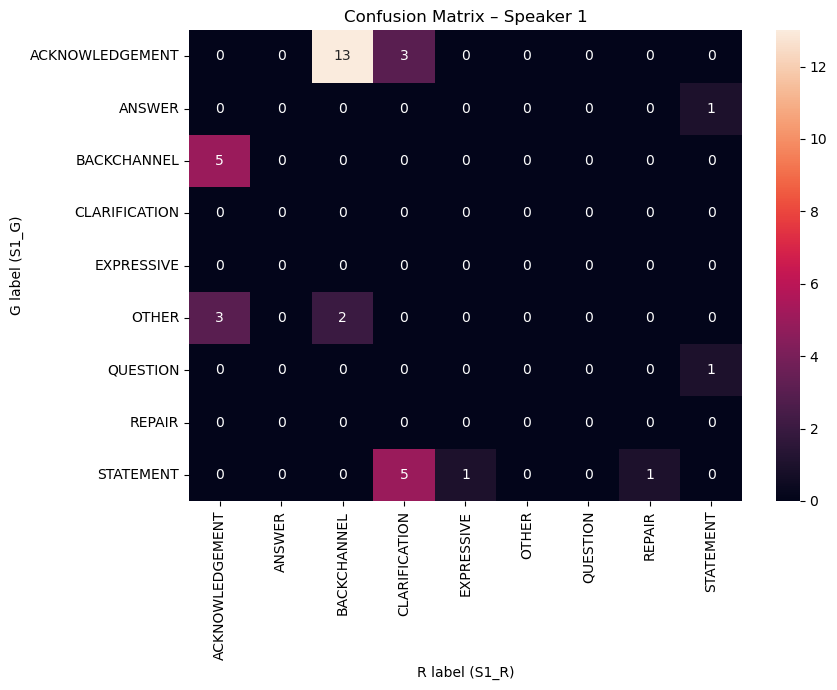

In [77]:
plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("R label (S1_R)")
plt.ylabel("G label (S1_G)")
plt.title("Confusion Matrix – Speaker 1")
plt.tight_layout()
plt.show()


## Error analysis for Speaker 2

In [ ]:
# ERROR ANALYSIS FOR SPEAKER 2

same_labels_S2 = []
diff_labels_S2 = []

for item in dicts_s2:
    g = item["S2_G"]
    r = item["S2_R"]
    
    if g == r:
        same_labels_S2.append({
            "utterance": item["utterance"],
            "S2_G": g,
            "S2_R": r
        })
    else:
        diff_labels_S2.append({
            "utterance": item["utterance"],
            "S2_G": g,
            "S2_R": r
        })

print("SAME LABELS S2")
print(same_labels_S2)
print()

print("DIFFERENT LABELS S2")
print(diff_labels_S2)

SAME LABELS S2
[{'utterance': '[remi]nisce', 'S2_G': 'BACKCHANNEL', 'S2_R': 'BACKCHANNEL'}, {'utterance': '(a)[bout] a shared memory', 'S2_G': 'STATEMENT', 'S2_R': 'STATEMENT'}, {'utterance': 'which memory would you like', 'S2_G': 'QUESTION', 'S2_R': 'QUESTION'}, {'utterance': 'mh=yea:h', 'S2_G': 'ACKNOWLEDGEMENT', 'S2_R': 'ACKNOWLEDGEMENT'}, {'utterance': "°we- we'll probably spend more than five minutes finding a memory°", 'S2_G': 'STATEMENT', 'S2_R': 'STATEMENT'}, {'utterance': 'u[:h]', 'S2_G': 'OTHER', 'S2_R': 'OTHER'}, {'utterance': '↓°yeah°', 'S2_G': 'ACKNOWLEDGEMENT', 'S2_R': 'ACKNOWLEDGEMENT'}, {'utterance': '>how do we do this<', 'S2_G': 'QUESTION', 'S2_R': 'QUESTION'}, {'utterance': 'do you just launch into the memory?', 'S2_G': 'QUESTION', 'S2_R': 'QUESTION'}, {'utterance': "[°I (.)] don't know°", 'S2_G': 'ANSWER', 'S2_R': 'ANSWER'}, {'utterance': 'no i like the memory', 'S2_G': 'ANSWER', 'S2_R': 'ANSWER'}, {'utterance': "[yeah i] like that memory (.) 'cause that was (0.4) w

In [79]:
rows_for_table_S2 = []

for e in diff_labels_S2:
    u = "\n".join(textwrap.wrap(e["utterance"], width=60))
    rows_for_table_S2.append([u, e["S2_G"], e["S2_R"]])

print(tabulate(
    rows_for_table_S2,
    headers=["utterance", "S2_G", "S2_R"],
    tablefmt="fancy_grid"
))


╒═════════════════════════════════════════════════════════════╤═════════════════╤═════════════════╕
│ utterance                                                   │ S2_G            │ S2_R            │
╞═════════════════════════════════════════════════════════════╪═════════════════╪═════════════════╡
│ °that was a good one°                                       │ EXPRESSIVE      │ STATEMENT       │
├─────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ yea::h↑                                                     │ EMOTIVE         │ EXPRESSIVE      │
├─────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ just tryin' to think of what like (1.4) it means            │ STATEMENT       │ ANSWER          │
├─────────────────────────────────────────────────────────────┼─────────────────┼─────────────────┤
│ >it was our first trip<                                     │ STATEMENT       │ CLARIFICATION   │


In [80]:

df_S2 = pd.DataFrame(diff_labels_S2)


used_labels_S2 = sorted(set(df_S2["S2_G"]) | set(df_S2["S2_R"]))


conf_matrix_S2 = pd.DataFrame(0, index=used_labels_S2, columns=used_labels_S2)

for _, row in df_S2.iterrows():
    conf_matrix_S2.loc[row["S2_G"], row["S2_R"]] += 1

print(conf_matrix_S2)



                 ACKNOWLEDGEMENT  ANSWER  BACKCHANNEL  CLARIFICATION  EMOTIVE  \
ACKNOWLEDGEMENT                0       0            6              0        0   
ANSWER                         0       0            0              0        0   
BACKCHANNEL                    8       0            0              0        1   
CLARIFICATION                  0       0            0              0        0   
EMOTIVE                        0       0            0              0        0   
EXPRESSIVE                     0       0            0              0        0   
OTHER                          3       0            3              0        0   
QUESTION                       0       0            0              0        0   
REPAIR                         0       0            0              0        0   
STATEMENT                      0       1            1              2        0   

                 EXPRESSIVE  OTHER  QUESTION  REPAIR  STATEMENT  
ACKNOWLEDGEMENT           1      0        

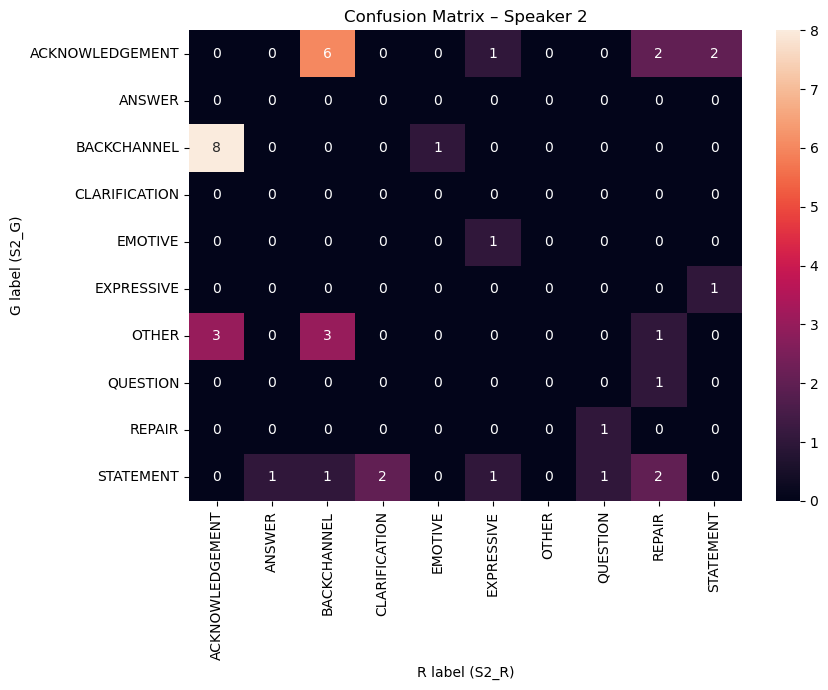

In [81]:
plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix_S2, annot=True, fmt="d")
plt.xlabel("R label (S2_R)")
plt.ylabel("G label (S2_G)")
plt.title("Confusion Matrix – Speaker 2")
plt.tight_layout()
plt.show()


In [82]:
#to be sure i take strings
df["utt_S1"] = df["Speaker1"].astype(str)
df["utt_S2"] = df["Speaker2"].astype(str)
df["G_S1"] = df["DialogueAct _ S1"].astype(str)
df["G_S2"] = df["DialogueAct _ S2"].astype(str)
df["R_S1"] = df["DialogueAct_S1_R"].astype(str)
df["R_S2"] = df["DialogueActs_S2_R"].astype(str)
df["LLM1"] = df["LLM_S1"].astype(str)
df["LLM2"] = df["LLM_S2"].astype(str)


In [83]:
def kappa(a, b):
    clean_A = []
    clean_B = []

    for x, y in zip(a, b):

        # keep only valid string labels
        if isinstance(x, str) and x != "nan" \
           and isinstance(y, str) and y != "nan":
            clean_A.append(x)
            clean_B.append(y)

    if not clean_A:   # no valid pairs
        return None

    return cohen_kappa_score(clean_A, clean_B)


## Kappa S1 and S2 - human vs human
I already did this above but it was useful to keep here as well.
Also, I was not able to find a command to run Holle and Rein's Kappa. 

In [84]:
k_S1_hh = kappa(df["G_S1"], df["R_S1"])
print("κ(S1_G vs S1_R) =", k_S1_hh)

print()
k_S2_hh = kappa(df["G_S2"], df["R_S2"])
print("κ(S2_G vs S2_R) =", k_S2_hh)


κ(S1_G vs S1_R) = 0.4427650141072149

κ(S2_G vs S2_R) = 0.5512349965281222


## Kappa S1 - human vs LLM

In [85]:
k_S1_G_LLM = kappa(df["G_S1"], df["LLM1"])
k_S1_R_LLM = kappa(df["R_S1"], df["LLM1"])

print("Cohen κ for S1_G vs LLM_S1 =", k_S1_G_LLM)
print()
print("Cohen κ for S1_R vs LLM_S1) =", k_S1_R_LLM)


Cohen κ for S1_G vs LLM_S1 = 0.13104494595107152

Cohen κ for S1_R vs LLM_S1) = 0.05415361945109587


In [86]:
#i will go over columns btu i expect some instances to have NaN or empty
def clean_pairs(a, b):
    """ function to remove rows with nan or empty labels"""
    return [(x, y) for x, y in zip(a, b)
            if isinstance(x, str) and x.strip() != "" and x != "nan"
            and isinstance(y, str) and y.strip() != "" and y != "nan"]


Confusion Matrix — S1_G vs LLM_S1
                 ACKNOWLEDGEMENT  ACKNOWLEDGMENT  ANSWER  BACKCHANNEL  \
ACKNOWLEDGEMENT                4               0       3            1   
ACKNOWLEDGMENT                 0               0       0            0   
ANSWER                         0               0       2            0   
BACKCHANNEL                    1               0       1            1   
CLARIFICATION                  0               0       0            0   
EMOTIVE                        0               0       0            0   
EXPRESSIVE                     0               0       0            0   
OTHER                          2               1       0            2   
QUESTION                       1               0       0            0   
REPAIR                         0               0       0            0   
REQUEST                        0               0       0            0   
STATEMENT                      0               0       4            5   

                

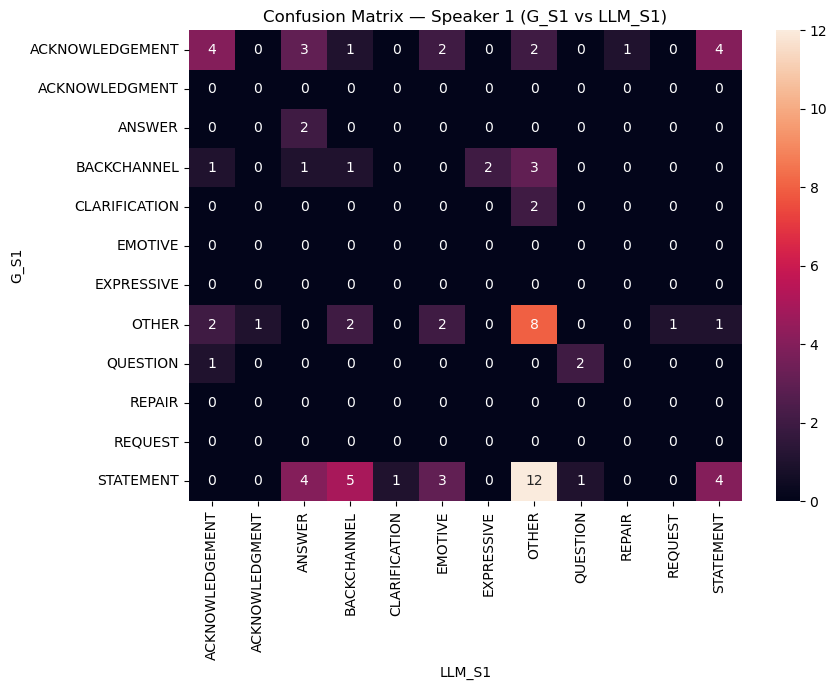

In [87]:
# THIS IS FOR S1_G VS LMM
pairs_S1_G_LLM = clean_pairs(df["G_S1"], df["LLM1"])
G1, L1 = zip(*pairs_S1_G_LLM)

labels_S1_G_LLM = sorted(set(G1) | set(L1))

cm_S1_G_LLM = pd.DataFrame(0, index=labels_S1_G_LLM, columns=labels_S1_G_LLM)

for g, l in pairs_S1_G_LLM:
    cm_S1_G_LLM.loc[g, l] += 1

print("Confusion Matrix — S1_G vs LLM_S1")
print(cm_S1_G_LLM)

plt.figure(figsize=(9,7))
sns.heatmap(cm_S1_G_LLM, annot=True, fmt="d")
plt.xlabel("LLM_S1")
plt.ylabel("G_S1")
plt.title("Confusion Matrix — Speaker 1 (G_S1 vs LLM_S1)")
plt.tight_layout()
plt.show()

Confusion Matrix — S1_R vs LLM_S1
                 ACKNOWLEDGEMENT  ACKNOWLEDGMENT  ANSWER  BACKCHANNEL  \
ACKNOWLEDGEMENT                2               0       1            0   
ACKNOWLEDGMENT                 0               0       0            0   
ANSWER                         0               0       1            0   
BACKCHANNEL                    4               0       3            1   
CLARIFICATION                  0               0       0            2   
EMOTIVE                        0               0       0            0   
EXPRESSIVE                     0               0       0            0   
OTHER                          1               1       0            2   
QUESTION                       0               0       0            0   
REPAIR                         0               0       0            0   
REQUEST                        0               0       0            0   
STATEMENT                      1               0       5            4   

                

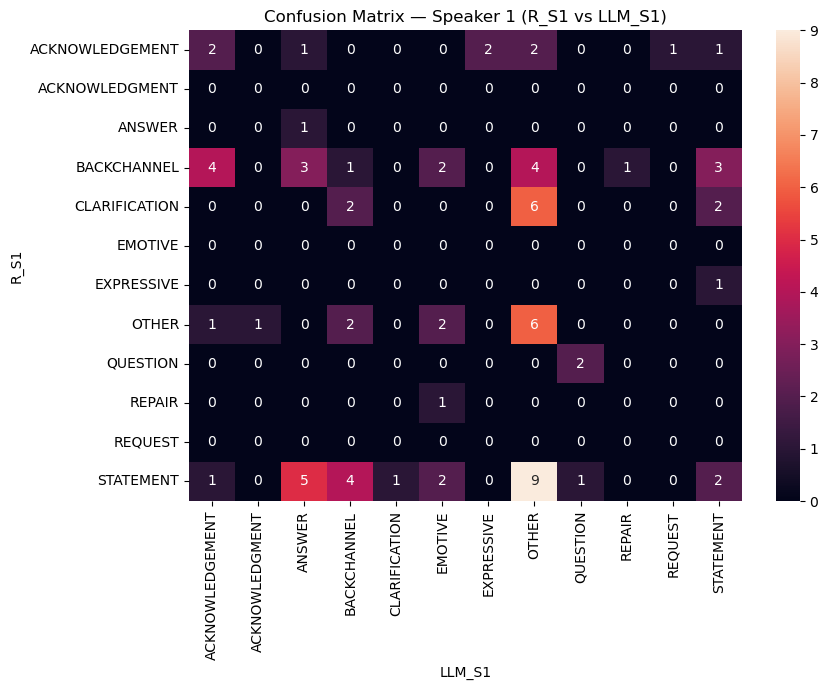

In [88]:
# THIS IS FOR S1_R VS LLM

pairs_S1_R_LLM = clean_pairs(df["R_S1"], df["LLM1"])
R1, L1b = zip(*pairs_S1_R_LLM)

labels_S1_R_LLM = sorted(set(R1) | set(L1b))

cm_S1_R_LLM = pd.DataFrame(0, index=labels_S1_R_LLM, columns=labels_S1_R_LLM)

for r, l in pairs_S1_R_LLM:
    cm_S1_R_LLM.loc[r, l] += 1

print("Confusion Matrix — S1_R vs LLM_S1")
print(cm_S1_R_LLM)

plt.figure(figsize=(9,7))
sns.heatmap(cm_S1_R_LLM, annot=True, fmt="d")
plt.xlabel("LLM_S1")
plt.ylabel("R_S1")
plt.title("Confusion Matrix — Speaker 1 (R_S1 vs LLM_S1)")
plt.tight_layout()
plt.show()


## Kappa S2 - human vs LLM

In [89]:
k_S2_G_LLM = kappa(df["G_S2"], df["LLM2"])
k_S2_R_LLM = kappa(df["R_S2"], df["LLM2"])

print("Cohen κ S2_G vs LLM_S2 =", k_S2_G_LLM)
print()
print("Cohen κ S2_R vs LLM_S2 =", k_S2_R_LLM)


Cohen κ S2_G vs LLM_S2 = 0.0910775971016935

Cohen κ S2_R vs LLM_S2 = 0.12369251203719067


Confusion Matrix — S2_G vs LLM_S2
                 ACKNOWLEDGEMENT  ANSWER  BACKCHANNEL  CLARIFICATION  \
ACKNOWLEDGEMENT                3       3            1              0   
ANSWER                         0       2            0              0   
BACKCHANNEL                    5       2            4              0   
CLARIFICATION                  0       0            0              0   
DIRECTIVE                      0       0            0              0   
EMOTIVE                        1       0            0              0   
EXPRESSIVE                     1       0            0              0   
OTHER                          1       3            3              0   
QUESTION                       0       1            0              0   
REPAIR                         0       0            0              0   
REQUEST                        0       0            0              0   
STATEMENT                      4       7            1              3   

                 DIRECTIVE  E

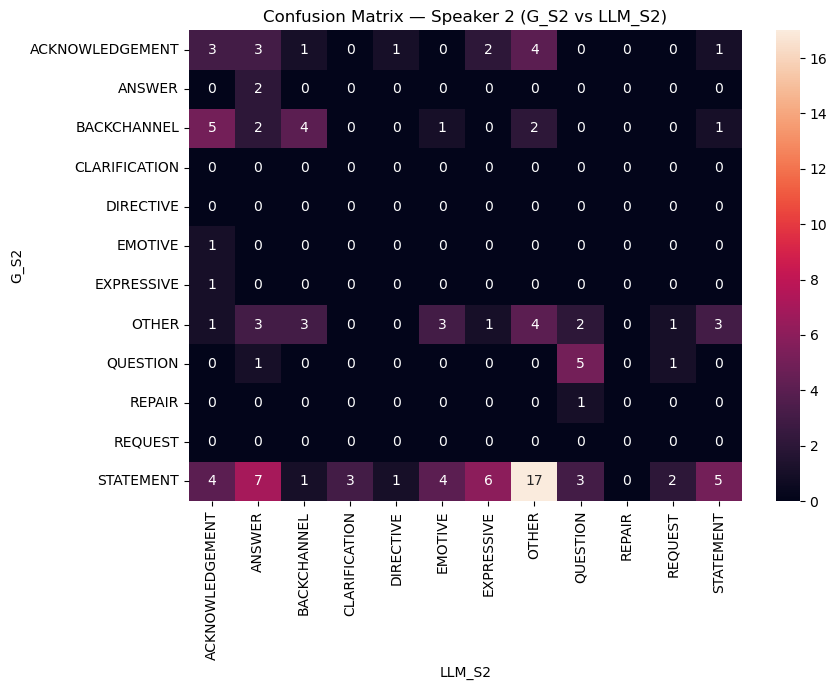

In [90]:
#this is S2_G VS LLM
pairs_S2_G_LLM = clean_pairs(df["G_S2"], df["LLM2"])
G2, L2 = zip(*pairs_S2_G_LLM)

labels_S2_G_LLM = sorted(set(G2) | set(L2))

cm_S2_G_LLM = pd.DataFrame(0, index=labels_S2_G_LLM, columns=labels_S2_G_LLM)

for g, l in pairs_S2_G_LLM:
    cm_S2_G_LLM.loc[g, l] += 1

print("Confusion Matrix — S2_G vs LLM_S2")
print(cm_S2_G_LLM)

plt.figure(figsize=(9,7))
sns.heatmap(cm_S2_G_LLM, annot=True, fmt="d")
plt.xlabel("LLM_S2")
plt.ylabel("G_S2")
plt.title("Confusion Matrix — Speaker 2 (G_S2 vs LLM_S2)")
plt.tight_layout()
plt.show()



Confusion Matrix — S2_R vs LLM_S2
                 ACKNOWLEDGEMENT  ANSWER  BACKCHANNEL  CLARIFICATION  \
ACKNOWLEDGEMENT                5       4            2              0   
ANSWER                         0       2            0              1   
BACKCHANNEL                    3       4            3              0   
CLARIFICATION                  1       0            0              0   
DIRECTIVE                      0       0            0              0   
EMOTIVE                        0       0            1              0   
EXPRESSIVE                     1       0            0              0   
OTHER                          1       0            2              0   
QUESTION                       0       1            0              0   
REPAIR                         0       0            0              0   
REQUEST                        0       0            0              0   
STATEMENT                      4       7            1              2   

                 DIRECTIVE  E

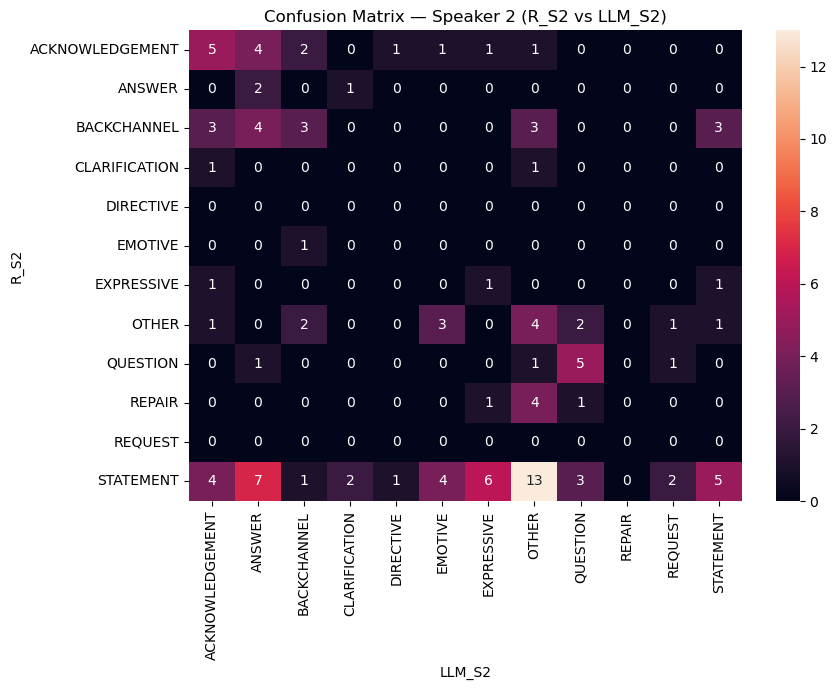

In [91]:
#this is S2_R VS LLM

pairs_S2_R_LLM = clean_pairs(df["R_S2"], df["LLM2"])
R2, L2b = zip(*pairs_S2_R_LLM)

labels_S2_R_LLM = sorted(set(R2) | set(L2b))

cm_S2_R_LLM = pd.DataFrame(0, index=labels_S2_R_LLM, columns=labels_S2_R_LLM)

for r, l in pairs_S2_R_LLM:
    cm_S2_R_LLM.loc[r, l] += 1

print("Confusion Matrix — S2_R vs LLM_S2")
print(cm_S2_R_LLM)

plt.figure(figsize=(9,7))
sns.heatmap(cm_S2_R_LLM, annot=True, fmt="d")
plt.xlabel("LLM_S2")
plt.ylabel("R_S2")
plt.title("Confusion Matrix — Speaker 2 (R_S2 vs LLM_S2)")
plt.tight_layout()
plt.show()
